## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
#import vaex
from IPython import display
from IPython.display import clear_output
import pyodbc

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_final

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final,\
                                                    align_features_and_labels_multi_v9

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix
#print('hej')

2.2.0
C:\Users\PC\AppData\Local\Temp\tmpv5vj8jht\tensorboard_logs


## Extracting data

In [2]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec (1).csv
1: aggregateTAQ_May2020_30sec (1).csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


# reading in the market data (done automatically atm)

### Dropping ETFS and market indices

In [3]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [4]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [5]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [6]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [7]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

In [8]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

In [9]:
########### Generate Features ################

n_feature_lags = 1

# features = generateFeatures_multi_final(data = data, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                       'macd_diff',
# #                                                       'macd_signal',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                       'sector'
#                                                    ], 
#                                    feature_lags = n_feature_lags
#                                      ,stockTable=stockTable)
features = generateFeatures_multi_final(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
# #                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                       'macd_diff',
#                                                       'macd_signal',
#                                                     'dis5',
#                                                     'dis10',
                                                      'sector'
                                                   ], 
                                   feature_lags = n_feature_lags
                                     ,sectorETFS=sectorETFS)

########### Generate Labels ################

n_classes = 5
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y,indices = align_features_and_labels_multi_v9(price_candles = price_candles, 
                                                 all_features = features,
                                                 prediction_horizon = 1, 
                                                 n_feature_lags = n_feature_lags, 
                                                 n_classes = n_classes, # 5,
                                                 safe_burn_in = False, 
                                                 data_sample = 'full',
                                                 splitType='global',
                                                 noise=False,
                                                 ticker_dummies=False)

0
            days  timestamps ticker
0     20200501.0         1.0   AAPL
1     20200501.0         2.0   AAPL
2     20200501.0         3.0   AAPL
3     20200501.0         4.0   AAPL
4     20200501.0         5.0   AAPL
...          ...         ...    ...
7793  20200529.0       384.0   AAPL
7794  20200529.0       385.0   AAPL
7795  20200529.0       386.0   AAPL
7796  20200529.0       387.0   AAPL
7797  20200529.0       388.0   AAPL

[7798 rows x 3 columns]
(7798, 71) (7798, 3) (7798,)
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0         4.0   AAPL
4  20200501.0         5.0   AAPL
5  20200501.0         6.0   AAPL
6  20200501.0         7.0   AAPL
7  20200501.0         8.0   AAPL
8  20200501.0         9.0   AAPL
9  20200501.0        10.0   AAPL
         days  timestamps ticker
0  20200501.0         1.0   AAPL
1  20200501.0         2.0   AAPL
2  20200501.0         3.0   AAPL
3  20200501.0    

## Splitting the data

## Adding ticker dummies

In [10]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

In [11]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0',
       ...
       'd_ticker_SO', 'd_ticker_SRE', 'd_ticker_T', 'd_ticker_TM',
       'd_ticker_TSLA', 'd_ticker_TSM', 'd_ticker_UNP', 'd_ticker_UPS',
       'd_ticker_V', 'd_ticker_WMT'],
      dtype='object', length=126)

## Constructing our final train/validation sets

In [12]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.astype({'days':int,'timestamps':int}).sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

test_index = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].index
test_index = tempIndices.loc[test_index]

train_index = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].index
train_index = tempIndices.loc[train_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(343145, 126)
(343145, 1)
(85745, 126)
(85745, 1)


In [13]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

## Pre-processing

In [14]:
{i:colname for i,colname in enumerate(X_train.columns)}

{0: 'open_lag0',
 1: 'high_lag0',
 2: 'low_lag0',
 3: 'close_lag0',
 4: 'spread_open_lag0',
 5: 'spread_high_lag0',
 6: 'spread_low_lag0',
 7: 'spread_close_lag0',
 8: 'bidsize_open_lag0',
 9: 'bidsize_high_lag0',
 10: 'bidsize_low_lag0',
 11: 'bidsize_close_lag0',
 12: 'ofrsize_open_lag0',
 13: 'ofrsize_high_lag0',
 14: 'ofrsize_low_lag0',
 15: 'ofrsize_close_lag0',
 16: 'relReturns_DIA_lag0',
 17: 'relReturns_IDU_lag0',
 18: 'relReturns_IYC_lag0',
 19: 'relReturns_IYE_lag0',
 20: 'relReturns_IYG_lag0',
 21: 'relReturns_IYH_lag0',
 22: 'relReturns_IYJ_lag0',
 23: 'relReturns_IYK_lag0',
 24: 'relReturns_IYM_lag0',
 25: 'relReturns_IYR_lag0',
 26: 'relReturns_IYW_lag0',
 27: 'relReturns_IYZ_lag0',
 28: 'relReturns_QQQ_lag0',
 29: 'relReturns_SPY_lag0',
 30: 'open_lag1',
 31: 'high_lag1',
 32: 'low_lag1',
 33: 'close_lag1',
 34: 'spread_open_lag1',
 35: 'spread_high_lag1',
 36: 'spread_low_lag1',
 37: 'spread_close_lag1',
 38: 'bidsize_open_lag1',
 39: 'bidsize_high_lag1',
 40: 'bidsize_

In [15]:
# Creating one ppdict for individual preprocessings
# ppdict1 = {'open':'minmax',
#           'high':'log',
#           'low':'log',
#           'close':'std'}
# splitpoint = 32

# # Standardize some features
# ppdict1 = {i:'std' for i in train_ds.columns[0:splitpoint]} 
# # Keep some in actual levels (Dummies in this case).
# ppdict2 = {i:'act' for i in train_ds.columns[splitpoint:]}

pre_procesing_applied = 'std'

# Merging the two
# ppdict = {**ppdict1,**ppdict2}

if  pre_procesing_applied == 'None':
    # do nothing here
    pass

elif  pre_procesing_applied == 'std':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

if pre_procesing_applied not in ['None','stacked']:
    X_train,X_test = pre_processing_final(X_train,X_test,ppdict)

In [16]:
X_train.iloc[:,0].mean(),X_train.iloc[:,0].std()

(-4.366881544104378e-17, 1.0000014571127978)

In [17]:
X_test.iloc[:,0].mean(),X_test.iloc[:,0].std()

(0.0002332618381423609, 0.9248626061424452)

## Prepping for models

In [18]:
N_VALIDATION = y_test.shape[0] #int(1e3)
N_TRAIN = y_train.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 50

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X_train.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(343145, 85745, 428890, 1340, 1311, 67000)

In [19]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([16986, 17326, 17371, 17051, 17011], dtype=int64))

In [20]:
y_test

,0
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
85740,0.0
85741,0.0
85742,0.0
85743,0.0


## A Logistic Regression model in TF/Keras

In [21]:
one_hot = True
# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

if one_hot:
    y_train_1h = one_hot_encode(y_train.values.astype(np.int), n_classes)
    y_test_1h = one_hot_encode(y_test.values.astype(np.int), n_classes)

In [22]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(5,
                       input_shape=(FEATURES,),
                       activation='softmax',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),#'categorical_crossentropy',
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping
             #tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            X_train, #train_features,
                            y_train_1h, #y_train, #train_labels,
                            batch_size=3300, #BATCH_SIZE,
                            epochs=50, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(X_test, y_test_1h),
                            verbose=0) #(val_features, val_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 635       
Total params: 635
Trainable params: 635
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.7966,  auc:0.5127,  loss:6.5241,  val_accuracy:0.7990,  val_auc:0.5135,  val_loss:3.4684,  
..................................................

In [23]:
model.evaluate(X_test,  y_test_1h, verbose=2)

2680/2680 - 9s - loss: 1.6031 - accuracy: 0.8001 - auc: 0.5571


[1.6031373739242554, 0.8000723719596863, 0.5570911169052124]

In [24]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [25]:
# import datetime
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# %tensorboard --logdir logs

In [26]:
probs= model.predict(X_test, verbose=1)
probs

2680/2680 [==============================] - 8s 3ms/step


array([[0.15152465, 0.1868311 , 0.22562028, 0.22686534, 0.20915866],
       [0.13692798, 0.1753966 , 0.2093188 , 0.24152751, 0.23682912],
       [0.15747474, 0.1885934 , 0.21189572, 0.22472152, 0.21731457],
       ...,
       [0.19472115, 0.20364322, 0.19556525, 0.20552123, 0.20054911],
       [0.19969787, 0.20475401, 0.19361527, 0.20455913, 0.19737369],
       [0.19074537, 0.1976937 , 0.19260508, 0.2137884 , 0.20516749]],
      dtype=float32)

## Update indices of data

In [27]:
X_test.set_index(pd.MultiIndex.from_frame(test_index), inplace=True)
X_train.set_index(pd.MultiIndex.from_frame(train_index), inplace=True)
X_test

open_lag0  high_lag0  low_lag0  close_lag0  \
days     timestamps ticker                                               
20200526 0          AAPL    -0.928467   0.617850 -1.177361    0.665338   
                    ABBV     0.975907   0.649053 -0.354990   -0.370518   
                    ABT     -0.323201   0.337016 -0.275916   -0.371731   
                    AEP     -0.574165   1.351137 -2.458363   -0.431839   
                    AMT      1.330209   1.023498 -5.131070    0.325826   
...                               ...        ...       ...         ...   
20200529 388        TSM      0.267303  -0.084234  0.388307   -0.562972   
                    UNP      0.045864  -0.162244  0.166900   -0.026086   
                    UPS      0.223015  -0.084234  0.293418   -0.340059   
                    V        0.001576  -0.006225  0.214344    0.090200   
                    WMT      0.769231   0.493035  0.340863   -0.232242   

                            spread_open_lag0  spread_high_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL            0.361580          0.114771   
                    ABBV            0.212871          0.036328   
                    ABT             0.780669          0.418740   
                    AEP             0.631960          1.693447   
                    AMT             2.578697          3.046597   
...                                      ...               ...   
20200529 388        TSM            -0.246775         -0.306862   
                    UNP            -0.179180         -0.218614   
                    UPS            -0.206218         -0.248030   
                    V              -0.152142         -0.218614   
                    WMT            -0.192699         -0.218614   

                            spread_low_lag0  spread_close_lag0  \
days     timestamps ticker                                       
20200526 0          AAPL          -0.211230          -0.134590   
                    ABBV          -0.211230          -0.264928   
                    ABT           -0.211230          -0.004252   
                    AEP            0.362884           0.028332   
                    AMT           -0.125113           1.152496   
...                                     ...                ...   
20200529 388        TSM           -0.211230          -0.297512   
                    UNP           -0.211230          -0.264928   
                    UPS           -0.211230          -0.297512   
                    V             -0.211230          -0.248636   
                    WMT           -0.211230          -0.297512   

                            bidsize_open_lag0  bidsize_high_lag0  ...  \
days     timestamps ticker                                        ...   
20200526 0          AAPL            -0.062813          -0.116091  ...   
                    ABBV            -0.193666          -0.193808  ...   
                    ABT             -0.156280          -0.193808  ...   
                    AEP             -0.193666          -0.217124  ...   
                    AMT             -0.174973          -0.217124  ...   
...                                       ...                ...  ...   
20200529 388        TSM             -0.006733          -0.061688  ...   
                    UNP             -0.174973          -0.178265  ...   
                    UPS             -0.193666          -0.178265  ...   
                    V               -0.193666          -0.131634  ...   
                    WMT             -0.156280          -0.209352  ...   

                            d_ticker_SO  d_ticker_SRE  d_ticker_T  \
days     timestamps ticker                                          
20200526 0          AAPL              0             0           0   
                    ABBV              0             0           0   
                    ABT               0             0           0   
                    AEP               0             

In [28]:
preds = pd.DataFrame(model.predict(X_test, verbose=1))
preds
# preds[0] = 1 - preds[1]

2680/2680 [==============================] - 6s 2ms/step


,0,1,2,3,4
0,0.151525,0.186831,0.225620,0.226865,0.209159
1,0.136928,0.175397,0.209319,0.241528,0.236829
2,0.157475,0.188593,0.211896,0.224722,0.217315
3,0.132261,0.166126,0.206525,0.237789,0.257299
4,0.215987,0.208162,0.200436,0.196581,0.178835
...,...,...,...,...,...
85740,0.189148,0.198688,0.200062,0.208956,0.203146
85741,0.198098,0.205316,0.195312,0.204149,0.197125
85742,0.194721,0.203643,0.195565,0.205521,0.200549
85743,0.199698,0.204754,0.193615,0.204559,0.197374


In [29]:
preds['class'] = preds.iloc[:,0:5].values.argmax(axis=1)
preds['confidence'] = preds.iloc[:,0:-2].values.max(axis=1)
preds = preds.set_index(X_test.index) #.loc[(20200526,0)]
preds

0         1         2         3         4  \
days     timestamps ticker                                                     
20200526 0          AAPL    0.151525  0.186831  0.225620  0.226865  0.209159   
                    ABBV    0.136928  0.175397  0.209319  0.241528  0.236829   
                    ABT     0.157475  0.188593  0.211896  0.224722  0.217315   
                    AEP     0.132261  0.166126  0.206525  0.237789  0.257299   
                    AMT     0.215987  0.208162  0.200436  0.196581  0.178835   
...                              ...       ...       ...       ...       ...   
20200529 388        TSM     0.189148  0.198688  0.200062  0.208956  0.203146   
                    UNP     0.198098  0.205316  0.195312  0.204149  0.197125   
                    UPS     0.194721  0.203643  0.195565  0.205521  0.200549   
                    V       0.199698  0.204754  0.193615  0.204559  0.197374   
                    WMT     0.190745  0.197694  0.192605  0.213788  0.205167   

                            class  confidence  
days     timestamps ticker                     
20200526 0          AAPL        3    0.226865  
                    ABBV        3    0.241528  
                    ABT         3    0.224722  
                    AEP         4    0.237789  
                    AMT         0    0.215987  
...                           ...         ...  
20200529 388        TSM         3    0.208956  
                    UNP         1    0.205316  
                    UPS         3    0.205521  
                    V           1    0.204754  
                    WMT         3    0.213788  

[85745 rows x 7 columns]

In [30]:
np.unique(preds['class'], return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 6544, 22084,  7797, 39421,  9899], dtype=int64))

In [31]:
probs

array([[0.15152465, 0.1868311 , 0.22562028, 0.22686534, 0.20915866],
       [0.13692798, 0.1753966 , 0.2093188 , 0.24152751, 0.23682912],
       [0.15747474, 0.1885934 , 0.21189572, 0.22472152, 0.21731457],
       ...,
       [0.19472115, 0.20364322, 0.19556525, 0.20552123, 0.20054911],
       [0.19969787, 0.20475401, 0.19361527, 0.20455913, 0.19737369],
       [0.19074537, 0.1976937 , 0.19260508, 0.2137884 , 0.20516749]],
      dtype=float32)

In [32]:
## Setting one day to investigate
temp = preds.loc[20200526,0]

probs = pd.DataFrame(columns=['ticker','prob','class'])
## Adding class 0
probs[['ticker','prob','class']] = temp[temp['class'] == 0][[0,'class']].reset_index().copy(deep=True)
# ## Adding class 4
probs = pd.concat([probs,temp[temp['class'] == 4][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})],
                  axis=0)

# ## Adding other classes - NB: We have randomly selected the probs from columns 4 - we would have chosen any of the columns.
# probs = pd.concat([probs,temp[(temp['class'] != 0)|(temp['class'] != 4)][[4,'class']].reset_index().copy(deep=True)])
probs = pd.concat([probs,
                   temp[~temp['class'].isin([0,4])][[4,'class']].reset_index().copy(deep=True).rename(columns={4:'prob'})]).reset_index(drop=True)
# # setting the probs of classes different from 0 and 4 to zero.
probs.loc[~probs['class'].isin([0,4]),'prob'] = 0

# Weights
probs['weight'] = probs.prob / probs.prob.sum()

# directions
probs['direction'] = 0#probs.prob / probs.prob.sum()
probs.loc[probs['class'].isin([0]),'direction'] = -1
probs.loc[probs['class'].isin([4]),'direction'] = 1

probs = probs.sort_values(['class','ticker'])

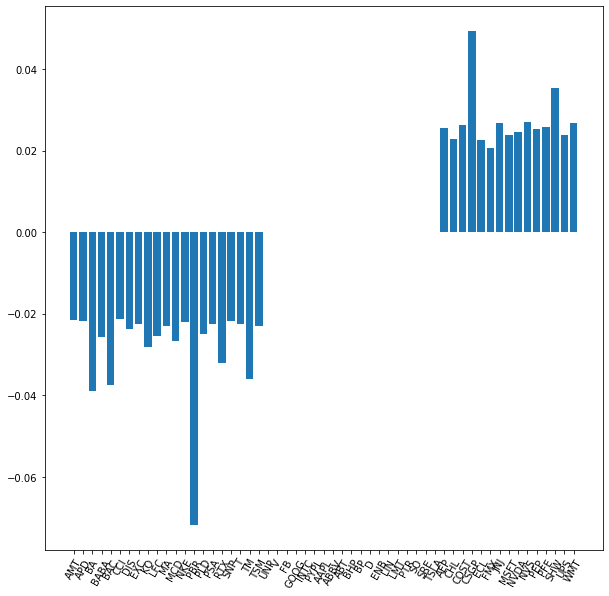

In [33]:
plt.figure(figsize=(10,10))
plt.bar(x = probs.ticker,
        height = probs.weight*probs.direction)
plt.xticks(rotation=60)
plt.show()

In [34]:
probs.prob.sum()

10.057644

In [35]:
probs.weight.sum()

1.0

In [36]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'INTC', 'JNJ', 'KO', 'LFC',
       'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA', 'NVS', 'PBR',
       'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX', 'SHW', 'SNP',
       'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS', 'V', 'WMT'],
      dtype=object)

## Introducing the stop-loss / profit-goal option

In [37]:
def returns(price_data,horizon):
    
    return (price_data.values[1:]/price_data.values[0:-1])-1


In [38]:
### Recreating the price series for each tradable ticker
X_train_temp = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].copy(deep=True).reset_index(drop=True)

actual_series_train = np.array([X_train_temp[X_train_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_train_temp.columns\
                          if 'd_ticker' in i])

cp_x_train = pd.DataFrame(actual_series_train.T,
                         columns=data.Ticker.unique())


### Recreating the price series for each tradable ticker
X_test_temp = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].copy(deep=True).reset_index(drop=True)

actual_series_test = np.array([X_test_temp[X_test_temp[i]==1].close_lag0.reset_index(drop=True).values for i in X_test_temp.columns\
                          if 'd_ticker' in i])
indexed_series_test = np.divide(actual_series_test,actual_series_test.T[0].reshape(-1,1))*100

cp_x_test = pd.DataFrame(indexed_series_test.T,
                         columns=data.Ticker.unique())

### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

### Recreating the price series for each ETF

actual_series_etfs = np.array([sector_test[sector_test['Ticker']==i].close.reset_index(drop=True).values\
                          for i in sector_test.Ticker.unique()])

indexed_series_etfs = np.divide(actual_series_etfs,actual_series_etfs.T[0].reshape(-1,1))*100

cp_sector_test = pd.DataFrame(indexed_series_etfs.T,
                         columns=sector_test.Ticker.unique())

## Simple way of calculating the standard deviation over a fixed window
The online optione below can be adjusted based on [this](https://lingpipe-blog.com/2009/07/07/welford-s-algorithm-delete-online-mean-variance-deviation/) reference, to do the same.

In [39]:
horizon = 5

print(cp_x_train.iloc[-horizon:,0:2])
returns_container = returns(cp_x_train.iloc[-(horizon+1):,:],
                            horizon)
max_steps = 0
output_container = np.zeros((max_steps+1,
                             len(data.Ticker.unique())))

output_container[0] = np.std(returns_container,axis=0)
for i,j in enumerate(np.arange(max_steps)):

    returns_container[0:-1] = returns_container[1:]
    print(i)
    if i == 0:
        
        returns_container[-1] = (actual_series_test.T[i]/actual_series_train.T[-1])-1
    
    else:
        
        returns_container[-1] = (actual_series_test.T[i]/actual_series_test.T[i-1])-1
    
    output_container[i+1] = np.std(returns_container,axis=0)

         AAPL    ABBV
6234  318.340  91.875
6235  318.475  91.895
6236  318.690  91.970
6237  318.850  91.950
6238  318.850  92.115


## Online standard deviation calculations

In [40]:
def online_std(initial_vals,horizon,new_vals,count=0,m2=0):
    
    ## We take a set of initial values, from which we calculate a running mean
    
    if count == 0:
        count = horizon + 1
        
    else:
        count += 1
    print(count)
    
    updated_vals = initial_vals + ((new_vals[0] - initial_vals) / count)

    m2 = initial_vals*(count-1) + (new_vals[0] - initial_vals)*(new_vals[0] - updated_vals)

    return updated_vals,m2,count

def online_std_fixed(old_mean,old_vals,new_vals,horizon):
    
    ## We take a set of initial values, from which we calculate a running mean

    updated_mean = old_mean + ((new_vals - old_vals) / horizon)

    m2 = old_mean*horizon + (new_vals - old_mean)*(new_vals - updated_mean)

    return updated_mean,m2,horizon

# Backtest module

In [69]:
'''
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

2) Max_positions: Check if the specified number of max positions results in an uneven split? like max position = 9.
'''


class backtest():
    def __init__(self,
                 X_test,
#                  X_train,
                 data,
                 preds,
                 weight_scheme,
                 rebal_scheme,
                 strategy_scheme,
                 # rebal_init_data,
                 # rebal_last_known_price,
                 # rebal_lookback_horizon,
                 # rebal_risk_aversion,
                 max_steps,
                 max_positions,
                 n_classes,
                 slpg_warning = False,
                 slpg_input = {},
                 verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'

        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.hist_directions = np.zeros((max_steps,len(self.all_tickers)))
        self.hist_prev_weights = np.zeros((max_steps,len(self.all_tickers)))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.strategy_scheme = strategy_scheme
        self.rebal_scheme = rebal_scheme
        self.slpg_warning = slpg_warning
        self.slpg_init_data = slpg_input['init_data']
        self.slpg_last_known_price = slpg_input['last_known_price']
        self.slpg_lookback_horizon = slpg_input['lookback_horizon']
        self.slpg_risk_aversion = slpg_input['risk_aversion']
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')

    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        print(self.all_tickers,'\n')

        if self.slpg_warning: # slpg: Stop Loss / Profit Goal

            self.returns_container = returns(self.slpg_init_data,#cp_x_train.iloc[-(self.rebal_lookback_horizon+1):,:]
                                        self.slpg_lookback_horizon)

#             self.output_container = np.zeros((self.max_steps+1,
#                                          len(self.all_tickers)))
            self.output_container = np.zeros((self.max_steps,
                                         len(self.all_tickers)))

#             self.output_container[0] = np.std(self.returns_container,axis=0)

        self.ticker_dict = {i:j for i,j in enumerate(self.all_tickers)}

        print('Size of returns container: ', self.returns_container.shape)
        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            print(ts)
            print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]
#             print(close_info)
            self.update_positions(ts, close_info, ts_preds)#,self.rebal_scheme

            self.t += 1

        print(f'run function finished at step {self.t}, time: {ts}')

    def update_positions(self, ts, close_info, ts_preds):#,rebal_scheme

        # Long positions
        long_pos = ts_preds[ts_preds['class'] == (self.n_classes - 1)].sort_values('confidence',
                                                                                   ascending=False)
        # Short positions
        short_pos = ts_preds[ts_preds['class'] == 0].sort_values('confidence',ascending=False)

        # The choice of strategy scheme determines the actions going forward
        if self.strategy_scheme == 'max_pos':

            ## Open all available long positions if the number of available long positions are less than the
            ## intended number of long positions.
            if (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                long_list = long_pos.index.values
                short_list = short_pos.index.values

                if self.verbose:
                    print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_list)+\
                                                                                                                len(short_list),self.max_positions))
            ## If both the available long and short exceeds the needed:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

                long_list = long_pos.iloc[0:int(self.max_positions/2),:].index.values
                short_list = short_pos.iloc[0:int(self.max_positions/2),:].index.values

            ## If there are less long and excess short positions:
            elif (long_pos.shape[0] <= (self.max_positions / 2)) & (short_pos.shape[0] > (self.max_positions / 2)):

                long_list = long_pos.index.values
                short_list = short_pos.iloc[0:int(self.max_positions-long_pos.shape[0]),:].index.values

            ## If there are less short and excess long positions:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                long_list = long_pos.iloc[0:int(self.max_positions-short_pos.shape[0]),:].index.values
                short_list = short_pos.index.values

            ## Else return eror
            else:

                raise ValueError('Something is wrong - please investigate!')

        ## If "None" strategy scheme is chosen, all candicates are chosen.
        elif self.strategy_scheme == None:

            long_list = long_pos.index.values
            short_list = short_pos.index.values

        ## Else return eror
        else:

            raise ValueError('Something is wrong - please investigate!')

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # check if any new positions are made
        new_long = long_list[~np.isin(long_list, self.open_long_positions)]
        new_short = short_list[~np.isin(short_list, self.open_short_positions)]

        ###### check if any needs closed before we determine if any new ones should be
        ###### disregarded.

        ## Closing those that have changed signal.
        close_long = list(np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)])
        close_short = list(np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)])

        ## Meant to check if time to close positions due to stop loss or profit goal.
        ## However, at the moment we just inform about positions that exceeds either of the thresholds.
        if (self.t > 0) & (self.slpg_warning):

            positions_above_pg = np.where(self.hist_rets[self.t-1][0:-1]>(1+self.output_container[self.t-1]*self.slpg_risk_aversion[1]))[0]
            positions_below_sl = np.where(self.hist_rets[self.t-1][0:-1]<(1+self.output_container[self.t-1]*self.slpg_risk_aversion[0]*-1))[0]

            print('Number of positions above profit goal: ',len(positions_above_pg))

            if len(positions_above_pg) > 0:
                print('Positionns exceeding the profit goal: ',[(self.ticker_dict[i],i) for i in positions_above_pg],'\n')

            print('Number of positions below stop loss: ',len(positions_below_sl))

            if len(positions_below_sl) > 0:
                print('Positionns exceeding the stop loss: ',[(self.ticker_dict[i],i) for i in positions_below_sl])

        if self.verbose >= 1:
            print(f'\nclose_long: {close_long}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_long]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.strategy_scheme == 'max_pos':

            long_candidates = self.open_long_positions+list(new_long)
            short_candidates = self.open_short_positions+list(new_short)

            ## Checking if any of the new candidates should be included or any of the existing should be closed
            ## at the expense of a new.
            if (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) <= (self.max_positions / 2)):

                # Do nothing, sticking with the generated list, consisting of open positions and new buys!
                pass

                if self.verbose:
                    print("\n NOTE: The number of available positions are %i, compared to the intended %i.\n" % (len(long_candidates)+\
                                                                                                                len(short_candidates),
                                                                                                                 self.max_positions))
            ## If both the available long and short exceeds the needed:
            elif (len(long_candidates) > (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):

                ### Prepping the candidates
                temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values
                temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values

                # Determining the ranking of the new candidates
                new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]
                new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]

                # Determining the ranking of the existing positions
                open_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,self.open_long_positions)]
                open_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,self.open_short_positions)]

                # if some new buy candidates have a ranking that is outside the desired long positions,
                # we diregard that new buy.
                if max(new_long_ranking) > ((self.max_positions / 2) - 1):
                    new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

                ## Same for sell candidates
                if max(new_short_ranking) > ((self.max_positions / 2) - 1):
                    new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]

                ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                ## we close it.
                if max(open_long_ranking) > ((self.max_positions / 2) - 1):
                    self.open_long_positions = [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] <= ((self.max_positions / 2) - 1)]
                    close_long += [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] > ((self.max_positions / 2) - 1)]

                ## Same for sell candidates
                if max(open_short_ranking) > ((self.max_positions / 2) - 1):
                    self.open_short_positions = [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] <= ((self.max_positions / 2) - 1)]
                    close_short += [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] > ((self.max_positions / 2) - 1)]

            ## If there are less long and excess short positions:
            elif (len(long_candidates) <= (self.max_positions / 2)) & (len(short_candidates) > (self.max_positions / 2)):

                ## With less long candidates than needed, there is no need to do anything at this point, as all existing
                ## positions should be kept, unless they do not have a buy signal anymore but then they are dropped above,
                ## and new ones should be added.
                ## For the sell candidates we first identify if we need to adjust. If we do not need to adjust, we just
                ## proceed as normally.

                if len(short_candidates) >= (self.max_positions - len(long_candidates)):

                    temp_short = ts_preds[ts_preds.index.isin(short_candidates)].sort_values('confidence',ascending=False).index.values

                    ## Determining the ranking of the new candidates
                    new_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,new_short)]

                    # Determining the ranking of the existing positions
                    open_short_ranking = np.arange(len(temp_short))[np.isin(temp_short,self.open_short_positions)]

                    # if some new sell candidates have a ranking that is outside the neeeded short positions,
                    # we diregard that new sell.
                    if max(new_short_ranking) > ((self.max_positions / 2) - 1):
                        new_short = [j for i,j in enumerate(new_short) if new_short_ranking[i] <= ((self.max_positions / 2) - 1)]

                    ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                    ## we close it.
                    if max(open_short_ranking) > ((self.max_positions / 2) - 1):
                        self.open_short_positions = [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] <= ((self.max_positions / 2) - 1)]
                        close_short += [j for i,j in enumerate(self.open_short_positions) if open_short_ranking[i] > ((self.max_positions / 2) - 1)]

            ## If there are less short and excess long positions:
            elif (long_pos.shape[0] > (self.max_positions / 2)) & (short_pos.shape[0] <= (self.max_positions / 2)):

                ### Vice versa, compared to the if statement just above.

                ## With less sell candidates than needed, there is no need to do anything at this point, as all existing
                ## positions should be kept, unless they do not have a sell signal anymore but then they are dropped below,
                ## and new ones should be added.

                ## For the short candidates we first identify if we need to adjust. If we do not need to adjust, we just
                ## proceed as normally.
                if len(long_candidates) >= (self.max_positions - len(short_candidates)):

                    temp_long = ts_preds[ts_preds.index.isin(long_candidates)].sort_values('confidence',ascending=False).index.values

                    ## Determining the ranking of the new candidates
                    new_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,new_long)]

                    # Determining the ranking of the existing positions
                    open_long_ranking = np.arange(len(temp_long))[np.isin(temp_long,self.open_long_positions)]

                    # if some new sell candidates have a ranking that is outside the neeeded short positions,
                    # we diregard that new sell.
                    if max(new_long_ranking) > ((self.max_positions / 2) - 1):
                        new_long = [j for i,j in enumerate(new_long) if new_long_ranking[i] <= ((self.max_positions / 2) - 1)]

                    ## Sort of same check as above; if any existing positions have a raking above the intended number of positions
                    ## we close it.
                    if max(open_long_ranking) > ((self.max_positions / 2) - 1):
                        self.open_long_positions = [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] <= ((self.max_positions / 2) - 1)]
                        close_long += [j for i,j in enumerate(self.open_long_positions) if open_long_ranking[i] > ((self.max_positions / 2) - 1)]

            ## Else return eror
            else:

                raise ValueError('Something is wrong - please investigate!')

        if self.verbose >= 1:
            print(f'new_long: {new_long}')
            print(f'new_short: {new_short} \n')

        self.open_long_positions += [long_i for long_i in new_long]
        self.open_short_positions += [short_i for short_i in new_short]

        self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')
        
        ########## Calculating returns ##########
        
        if self.t > 0:
#             print('\nIndex 37 direction before return calculation: ',self.prev_close.iloc[37, 1],'\n')
            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction'] = -1
#             print('\nIndex 37 direction, before return but after adjustment: ',self.prev_close.iloc[37, 1],'\n')
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
            
#             print('Current ret, index 37: ',current_ret[37],'\n')
            
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_long)
            
#             print('\nIndex 37: ',boolcousin[37],'\n')
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values - 1
            
            ## We multiply with the opposite direction to get the correct return.
            current_ret[boolcousin] = (current_ret[boolcousin] * -self.prev_close[boolcousin].direction.values) + 1
#             print('Current ret with bool cousin, index 37: ',current_ret[37],'\n')
#             print('Prev close: \n\n',self.prev_close)
            ## Correcting the return of those we rebalance
            #self.prev_close.direction.values != 0&
            rebal_mask = (self.prev_close.direction.values != 0)&(~(np.isin(self.all_tickers,new_long)|\
                            np.isin(self.all_tickers,new_short)|np.isin(self.all_tickers,close_long)|
                            np.isin(self.all_tickers,close_short)))
            
#             print('rebal_mask: \n',rebal_mask,'\n')
            print('tickers of rebal_mask: \n',self.all_tickers[rebal_mask],'\n')
            
            # Preparing the generation of the new weights
            future_direction = self.prev_close.direction.copy(deep=True)
            
            # update directions for new positions
#             self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            future_direction[np.isin(self.all_tickers, new_long)] = 1
#             print('\nIndex 37 direction, after return calculation: ',self.prev_close.iloc[37, 1],'\n')
#             self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1
            future_direction[np.isin(self.all_tickers, new_short)] = -1
            
            # set directions == 0 for closed positions
#             self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction']  = 0
            future_direction[np.isin(self.all_tickers, close_long)] = 0
#             self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0
            future_direction[np.isin(self.all_tickers, close_short)] = 0
        
            if self.weight_scheme == 'constant':
                # update total portfolio returns for open positions
#                 self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
                # Set new weights
                new_weights = (1/future_direction.abs().sum())*future_direction.abs()*self.hist_rets[self.t-1,-1]
#                 print(self.hist_prev_weights)
            elif self.weight_scheme == 'prob':
#                 print('Predictions: \n',ts_preds,'\n')
                new_weights = ((ts_preds.confidence)*future_direction.abs())/((ts_preds.confidence)*future_direction.abs()).sum()
            
            print('direction of rebal:\n\n',self.prev_close.direction[rebal_mask],'\n')
        
            print('return before: \n\n',current_ret[rebal_mask],'\n')
            
            print('Raw weight today: \n\n',new_weights[rebal_mask],'\n')
            print('Raw weight yesterday: \n\n',self.hist_prev_weights[self.t - 1,rebal_mask],'\n')
            
            rel_weight = new_weights[rebal_mask] / self.hist_prev_weights[self.t - 1,rebal_mask]
            
            print('rel_weight: \n\n',rel_weight,'\n')
            print('1 - rel_weight: \n\n', 1 - rel_weight,'\n')
            
            print('Adjustment of return: ',((close_info[rebal_mask].close.values\
                                         *abs(self.prev_close[rebal_mask].direction.values)\
                                         +(close_info[rebal_mask].spread_close.values / 2)\
                                         *-1*self.prev_close[rebal_mask].direction.values)\
                                        /self.prev_close[rebal_mask].prev_close.values),'\n')
            
            current_ret[rebal_mask] =  rel_weight*current_ret[rebal_mask] +\
                                        (1 - rel_weight)*((close_info[rebal_mask].close.values\
                                         *abs(self.prev_close[rebal_mask].direction.values)\
                                         +(close_info[rebal_mask].spread_close.values / 2)\
                                         *-1*self.prev_close[rebal_mask].direction.values)\
                                        /self.prev_close[rebal_mask].prev_close.values)#- 1
            
            print('return after: \n\n',current_ret[rebal_mask],'\n')
            
            
#             print('rebal_mask_v2: \n',self.prev_close.direction.values != 0&~(np.isin(self.all_tickers,new_long)|\
#                             np.isin(self.all_tickers,new_short)|np.isin(self.all_tickers,close_long)|
#                             np.isin(self.all_tickers,close_short)),'\n')
            
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
            current_ret[self.prev_close.direction.values == 0] = 1
            
            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]
            
#             if self.weight_scheme == 'constant':
#                 # update total portfolio returns for open positions
# #                 self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
                
#                 # Set new weights
#                 self.hist_prev_weights[self.t,:] = (1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs()
# #                 print(self.hist_prev_weights)
#             elif self.weight_scheme == 'prob':
# #                 print('Predictions: \n',ts_preds,'\n')
#                 self.hist_prev_weights[self.t,:] = ((ts_preds.confidence)*self.prev_close.direction.abs())/((ts_preds.confidence)*self.prev_close.direction.abs()).sum()
            
            # update total portfolio returns for open positions
#             self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
#             print('Old way: ',(1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1],'\n')
            
#             print('Check 1: \n\n',current_ret*self.prev_close.direction.abs().values,'\n')
#             print('Check 2: \n\n',current_ret*self.prev_close.direction.abs().values*self.hist_prev_weights[self.t - 1],'\n')
#             print('Check 3: \n\n',(1+sum(((current_ret*self.prev_close.direction.abs().values) - 1)*self.hist_prev_weights[self.t - 1])),'\n')
            
#             print('New way: ',(1+sum(((current_ret*self.prev_close.direction.abs().values) - 1)*self.hist_prev_weights[self.t - 1])) * self.hist_rets[self.t - 1, -1],'\n')
            self.hist_rets[self.t, -1] = (1+sum(((current_ret*self.prev_close.direction.abs().values) - 1)*self.hist_prev_weights[self.t - 1])) * self.hist_rets[self.t - 1, -1]

            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
#             print('\nIndex 37 direction, after return calculation: ',self.prev_close.iloc[37, 1],'\n')
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1

            if self.slpg_warning:
                ## Roll back return matrix, to make room to the return coming in at the end of the period.
                self.returns_container[0:-1] = self.returns_container[1:]

                ## Include the new return.
                self.returns_container[-1] = (close_info.close.values/self.prev_close.prev_close)-1

                ## Updating the standard deviation of the returns
                self.output_container[self.t] = np.std(self.returns_container,axis=0)

            ## Updating the last seen price
            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            ## Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            ## Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2
            overlap = []
#             print(np.isin(new_long,close_long))
#             print(close_long)
            overlap += list(np.array(close_long)[np.isin(close_long, new_long)])
            if len(overlap) > 0:
                print('New longs in close long: ', overlap)

            overlap += list(np.array(new_long)[np.isin(new_long, close_long)])
            if len(overlap) > 0:
                print('Close longs in new long: ', overlap)

            overlap += list(np.array(close_short)[np.isin(close_short, new_short)])
            if len(overlap) > 0:
                print('New shorts in close short: ', overlap)

            overlap += list(np.array(new_short)[np.isin(new_short, close_short)])
            if len(overlap) > 0:
                print('Close shorts in new short: ', overlap)

            if len(overlap) > 0:
                print('######### Overlap between the new candidates and the close candidates #########')

            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_long), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0
            
            ## Setting the weights for the open positions in the next period.
            if self.weight_scheme == 'constant':
                # update total portfolio returns for open positions
#                 self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
                print('New weight v1:\n\n',new_weights,'\n')
                print('New weight v2:\n\n',(1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs(),'\n')
                # Set new weights
                self.hist_prev_weights[self.t,:] = (1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs()
#                 print(self.hist_prev_weights)
            elif self.weight_scheme == 'prob':
#                 print('Predictions: \n',ts_preds,'\n')
                self.hist_prev_weights[self.t,:] = ((ts_preds.confidence)*self.prev_close.direction.abs())/((ts_preds.confidence)*self.prev_close.direction.abs()).sum()
            
            # Save the directions
            self.hist_directions[self.t,:] = self.prev_close.direction.copy(deep=True)
#             
#             print('\nIndex 37 hist rets: ',self.hist_rets[:,37],'\n')

        else:

            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_long), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_short), 'direction']  = -1
            
            ## Initializing the weights
            if self.weight_scheme == 'constant':
                self.hist_prev_weights[self.t,:] = (1/self.prev_close.direction.abs().sum())*self.prev_close.direction.abs()
#                 print(self.hist_prev_weights)
            elif self.weight_scheme == 'prob':
#                 print('Predictions: \n',ts_preds,'\n')
                self.hist_prev_weights[self.t,:] = ((ts_preds.confidence)*self.prev_close.direction.abs())/((ts_preds.confidence)*self.prev_close.direction.abs()).sum()
#                 print((ts_preds.confidence)*self.prev_close.direction.abs())    
#                 print(self.hist_prev_weights)
            if self.slpg_warning:

                ## Place to update returns in the returns container
                # Roll back the returns one period
                self.returns_container[0:-1] = self.returns_container[1:]

                # Include the new return
                self.returns_container[-1] = (close_info.close.values/self.slpg_last_known_price)-1

                # Updating the standard deviation of the returns
                self.output_container[self.t] = np.std(self.returns_container,axis=0)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values

            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_long),'prev_close'] = close_info[np.isin(self.all_tickers, new_long)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_long)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_short),'prev_close'] = close_info[np.isin(self.all_tickers, new_short)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_short)].spread_close.values / 2)
            
            # Save the directions
            self.hist_directions[self.t,:] = self.prev_close.direction.copy(deep=True)

######### A little initialization ###########
max_steps = 6
slpg_lookback_horizon = 10
slpg_init_data = cp_x_train.iloc[-(slpg_lookback_horizon+1):,:]
slpg_last_known_price = cp_x_train.iloc[-1,:].T

slpg_input = {'init_data':slpg_init_data,
              'last_known_price':slpg_last_known_price,
              'lookback_horizon':slpg_lookback_horizon,
              'risk_aversion':(2,4)}

backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = 'constant',
                        rebal_scheme = 'slpg',
                        strategy_scheme = 'max_pos',### Options: 'max_pos',None
#                         rebal_init_data = rebal_init_data,
#                         rebal_last_known_price = rebal_last_known_price,
#                         rebal_lookback_horizon = rebal_lookback_horizon,
#                         rebal_risk_aversion = (2,4),
                        max_steps=max_steps,
                        max_positions = 2,
                        n_classes=5,
                        slpg_warning = True,
                        slpg_input = slpg_input,
                        verbose=True)
backtest_obj.run()


initial self.open_long_positions: []
initial self.open_short_positions: [] 

['AAPL' 'ABBV' 'ABT' 'AEP' 'AMT' 'APD' 'BA' 'BABA' 'BAC' 'BHP' 'BP' 'CCI'
 'CHL' 'COST' 'CSGP' 'D' 'DIS' 'ECL' 'ENB' 'EXC' 'FB' 'FMX' 'GOOG' 'INTC'
 'JNJ' 'KO' 'LFC' 'LIN' 'LMT' 'MA' 'MCD' 'MSFT' 'NKE' 'NVDA' 'NVS' 'PBR'
 'PEP' 'PFE' 'PLD' 'PSA' 'PTR' 'PYPL' 'RTX' 'SHW' 'SNP' 'SO' 'SRE' 'T'
 'TM' 'TSLA' 'TSM' 'UNP' 'UPS' 'V' 'WMT'] 

Size of returns container:  (10, 55)
[       0 20200526]


################ Period 0 ################


long_list: ['CSGP']
short_list: ['PBR'] 


close_long: []
close_short: [] 

Closing trades, status after:
all long: []
all short: [] 


 NOTE: The number of available positions are 2, compared to the intended 2.

new_long: ['CSGP']
new_short: ['PBR'] 

Opening new trades, status after:
all long: ['CSGP']
all short: ['PBR'] 

[       1 20200526]


################ Period 1 ################


long_list: ['SHW']
short_list: ['FMX'] 

Number of positions above profit goal:  0
Number

long_list: ['CSGP']
short_list: ['NKE'] 

Number of positions above profit goal:  0
Number of positions below stop loss:  2
Positionns exceeding the stop loss:  [('CSGP', 14), ('SHW', 43)]

close_long: []
close_short: ['GOOG'] 

Closing trades, status after:
all long: ['CSGP']
all short: [] 


 NOTE: The number of available positions are 2, compared to the intended 2.

new_long: []
new_short: ['NKE'] 

Opening new trades, status after:
all long: ['CSGP']
all short: ['NKE'] 

tickers of rebal_mask: 
 ['CSGP'] 

direction of rebal:

 CSGP    1
Name: direction, dtype: int64 

return before: 

 [0.99565101] 

Raw weight today: 

 CSGP    0.5
Name: direction, dtype: float64 

Raw weight yesterday: 

 [0.5] 

rel_weight: 

 CSGP    1.0
Name: direction, dtype: float64 

1 - rel_weight: 

 CSGP    0.0
Name: direction, dtype: float64 

Adjustment of return:  [0.99043818] 

return after: 

 [0.99565101] 

New weight v1:

 AAPL    0.0
ABBV    0.0
ABT     0.0
AEP     0.0
AMT     0.0
APD     0.0
BA

In [42]:
pot_returns = backtest_obj.hist_rets

### Storing returns in PD
pot_returns_pd = pd.DataFrame(pot_returns,columns = np.concatenate([data.Ticker.unique(),['Portfolio']]))

ticker_dict = {j:i for i,j in enumerate(pot_returns_pd.columns)}
ticker_dict

{'AAPL': 0,
 'ABBV': 1,
 'ABT': 2,
 'AEP': 3,
 'AMT': 4,
 'APD': 5,
 'BA': 6,
 'BABA': 7,
 'BAC': 8,
 'BHP': 9,
 'BP': 10,
 'CCI': 11,
 'CHL': 12,
 'COST': 13,
 'CSGP': 14,
 'D': 15,
 'DIS': 16,
 'ECL': 17,
 'ENB': 18,
 'EXC': 19,
 'FB': 20,
 'FMX': 21,
 'GOOG': 22,
 'INTC': 23,
 'JNJ': 24,
 'KO': 25,
 'LFC': 26,
 'LIN': 27,
 'LMT': 28,
 'MA': 29,
 'MCD': 30,
 'MSFT': 31,
 'NKE': 32,
 'NVDA': 33,
 'NVS': 34,
 'PBR': 35,
 'PEP': 36,
 'PFE': 37,
 'PLD': 38,
 'PSA': 39,
 'PTR': 40,
 'PYPL': 41,
 'RTX': 42,
 'SHW': 43,
 'SNP': 44,
 'SO': 45,
 'SRE': 46,
 'T': 47,
 'TM': 48,
 'TSLA': 49,
 'TSM': 50,
 'UNP': 51,
 'UPS': 52,
 'V': 53,
 'WMT': 54,
 'Portfolio': 55}

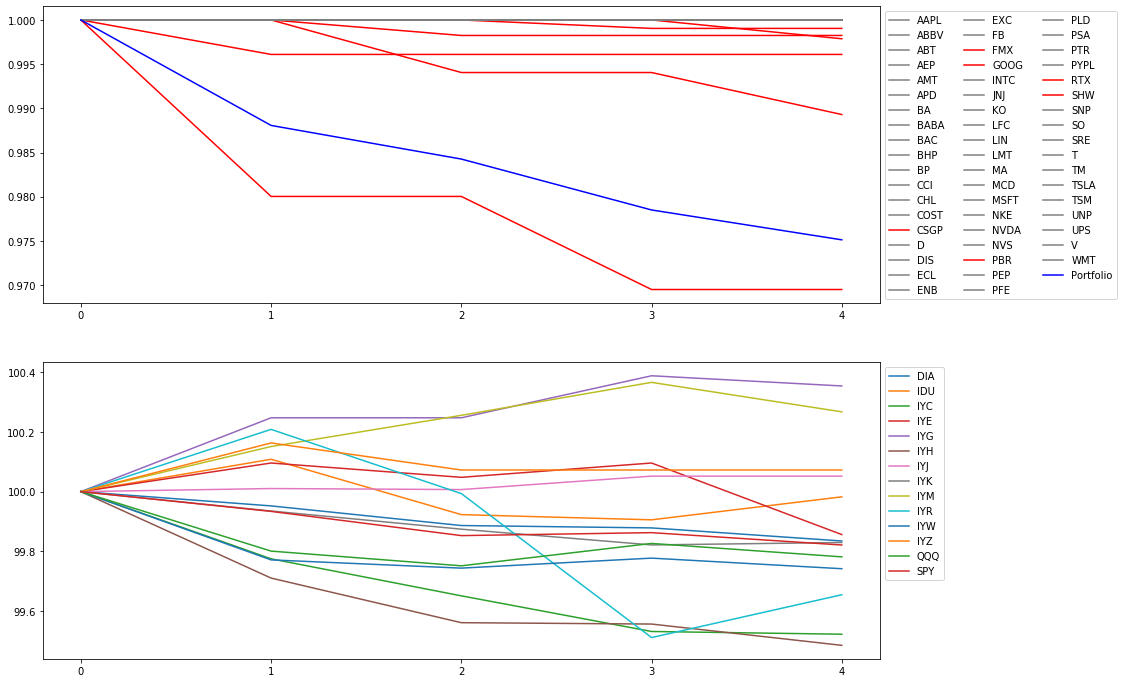

In [43]:
pnl_color = [('r' if pot_returns_pd.iloc[-1,i]<1 else 
             ('gray' if pot_returns_pd.iloc[-1,i]==1 else 
             'g')) for i in np.arange(pot_returns_pd.shape[1]-1)]
pnl_color += ['blue']

## True if plotting against ETFS of sectors and markets, else against tickers.
plot_against_market = True

### Tickers to investigate
## Either a list of tickers or None
tickers_to_plot = None#None['NVDA','BA']

### Setting up the subplot
fig,ax = plt.subplots(2,1,figsize=(15,12))

### Plotting the obtained returns
if tickers_to_plot is not None:
    ticker_location = [ticker_dict[i] for i in tickers_to_plot]
    pot_returns_pd.iloc[:,ticker_location].plot(color=np.array(pnl_color)[ticker_location],ax=ax[0])#.reshape(-1,50)#c=np.array(pnl_color[0:3])
else:
    pot_returns_pd.iloc[:,].plot(color=pnl_color,ax=ax[0])
ax[0].legend(ncol=3,
             bbox_to_anchor=[1,1])
ax[0].set_xticks(np.arange(max_steps))

### Plotting the actual price development

# Against the market
if plot_against_market:
    cp_sector_test.iloc[0:pot_returns_pd.shape[0],].plot(ax=ax[1])
else:
    if tickers_to_plot is not None:
        
        ticker_location = [ticker_dict[i] for i in tickers_to_plot]
        cp_x_test.iloc[0:pot_returns_pd.shape[0],ticker_location].plot(color='black',
                                                   ax=ax[1],legend=None)
    else:
        cp_x_test.iloc[0:pot_returns_pd.shape[0],].plot(color='black',
                                                   ax=ax[1],legend=None)
ax[1].legend(bbox_to_anchor=[1,1])
ax[1].set_xticks(np.arange(max_steps))

plt.show()

In [106]:
pot_returns_pd.loc[:,np.concatenate([sum(np.abs(backtest_obj.hist_directions))!=0,np.array(True).reshape(1)])].to_excel('../../pot_returns_1.xlsx')#pot_returns_pd.sum()!=max_steps
pot_returns_pd.loc[:,np.concatenate([sum(np.abs(backtest_obj.hist_directions))!=0,np.array(True).reshape(1)])]

,CSGP,FMX,GOOG,PBR,PFE,RTX,SHW,SNP,Portfolio
0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
1,0.980029,1.000000,1.0,0.996099,1.0,1.000000,1.000000,1.000000,0.988064
2,0.980029,0.998245,1.0,0.996099,1.0,1.000000,1.000000,1.000000,0.987197
3,0.980029,0.998245,1.0,0.996099,1.0,0.999045,0.996305,1.000000,0.984902
4,0.975344,0.998245,1.0,0.996099,1.0,0.999045,0.996305,0.996047,0.980601


In [90]:
# Directions
pd.DataFrame(backtest_obj.hist_directions,columns=cp_x_test.columns).loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../direction_1.xlsx')

In [86]:
pd.DataFrame(actual_series_test.T,columns=cp_x_test.columns).loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../prices_1.xlsx')

In [77]:
 # Save the directions
sum(np.abs(backtest_obj.hist_directions))!=0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [46]:
### Recreating the price series for each tradable ticker
# X_test_tempa = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

actual_series_spread_test = np.array([X_test_temp[X_test_temp[i]==1].spread_close_lag0.reset_index(drop=True).values for i in X_test_temp.columns\
                          if 'd_ticker' in i])
# indexed_series_test = np.divide(actual_series_test,actual_series_test.T[0].reshape(-1,1))*100

spread_x_test = pd.DataFrame(actual_series_spread_test.T,
                             columns=data.Ticker.unique())

In [87]:
spread_x_test.loc[0:5,sum(np.abs(backtest_obj.hist_directions))!=0].to_excel('../../spreads_1.xlsx')

In [48]:
preds.to_excel('../../predications_13_10_2020.xlsx')

In [117]:
X[(X.d_ticker_APD==1)&(tempIndices.days>=tempIndices.days.unique()[first_val_day])]

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
45229,-3.005,0.080,-3.005,239.555,9.08,9.08,0.63,0.79,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45230,0.110,1.475,-0.670,239.455,0.77,4.35,0.03,4.35,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45231,-0.570,1.130,-0.665,239.335,2.97,2.97,0.31,1.15,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45232,-0.255,0.790,-0.255,239.790,1.55,2.70,0.56,0.56,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
45233,0.430,0.435,-0.240,239.385,0.51,1.06,0.04,0.55,1.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46783,-0.125,0.220,-0.385,242.190,0.15,1.74,0.03,1.60,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
46784,-0.510,0.035,-0.700,242.455,1.11,1.60,0.07,0.15,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0
46785,-0.065,0.000,-0.285,242.505,0.12,0.44,0.04,0.21,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
46786,0.135,0.320,-0.125,242.360,0.23,0.54,0.06,0.38,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sectorETFS.reset_index()

In [ ]:
tempIndices

In [ ]:
### Restructuring the sector data

temp_sectorIndices = sectorETFS.reset_index()[['level_0','level_1','Ticker']].rename(columns={'level_0':'days',
                                                                                      'level_1':'timestamps',
                                                                                      'Ticker':'ticker'})
# print(temp_sectorIndices)
### Prep to sort
temp_sectorIndices = temp_sectorIndices.sort_values(['days','timestamps','ticker'])

### Sorting the data
temp_sectoretfs = sectorETFS.reset_index().loc[temp_sectorIndices.index,:]

### extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

### Splitting the data
# X_train = [tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
sector_test = temp_sectoretfs[temp_sectorIndices.days>=temp_sectorIndices.days.unique()[first_val_day]].reset_index(drop=True)

sector_test

In [ ]:
price_candles

In [ ]:
indices

In [ ]:
temp_sectorIndices

In [ ]:
# Let's have a proper split (along tickers & dates)
train_size = 0.8

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*0.8))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

In [ ]:
cp_x_test

In [ ]:
pot_returns_pd

In [ ]:
'''
            OLD VERSION
            
1) Each timestep
    -check for new positions
    -re-evaluate current positions
    -rebalance maybe
    -

'''


class backtest():
    def __init__(self, X_test, data, preds, weight_scheme, max_steps, max_positions, n_classes,verbose=False):

        self.all_tickers = data.Ticker.unique()
        self.open_long_positions = []#'AAPL','ABT','LFC'
        self.open_short_positions = []#'BAC','KO','ENB'
        self.ticker_dict = {}   # key: ticker, value: [open_price, direction, pnl]
        self.hist_rets = np.ones((max_steps,len(self.all_tickers)+1))
        self.pnl = []
        self.prev_close = pd.DataFrame(0, index=self.all_tickers, columns=['prev_close', 'direction'])
        self.t = 0

        self.X_test = X_test
        self.data = data
        self.preds = preds
        ## New
        self.weight_scheme = weight_scheme
        self.max_steps = max_steps
        self.max_positions = max_positions
        self.n_classes = n_classes
        self.verbose = verbose

        if self.verbose >= 1:
            print(f'initial self.open_long_positions: {self.open_long_positions}')
            print(f'initial self.open_short_positions: {self.open_short_positions} \n')



    def run(self):

        unique_timesteps = np.concatenate([[[i,j] for i in np.unique(self.X_test.index.get_level_values(1))] \
                                                  for j in np.unique(self.X_test.index.get_level_values(0))])
        print(self.all_tickers,'\n')

        while self.t < self.max_steps:

            ts = unique_timesteps[self.t]
            print('\n\n################ Period %i ################\n\n' % self.t)
            #print(i)
            try:
                ts_data = self.data.sort_index().loc[(ts[1], ts[0])] ## sort_index() to prevent the performance warning.
            except:
                pass
            if ts_data.shape == 0:
                pass

            #print(ts_data)

            close_info = ts_data[['close','spread_close','Ticker']].reset_index(drop=True)
            ts_preds = self.preds.loc[(ts[1], ts[0])]

            self.update_positions(ts, close_info, ts_preds)

            self.t += 1

        print(f'run function finished at step {self.t}, time: {ts}')

        #for ts in unique_timesteps[:2]:

        # for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
        #     #print(i)
        #     ts_data = data.loc[(ts[0], ts[1])]
        #     if ts_data.shape == 0:
        #         pass
        #         #print(i, 'hovhov')


    def update_positions(self, ts, close_info, ts_preds):

        #print(ts_preds, '\n')

        # use predictions to select what to hold
        long_list = ts_preds[ts_preds['class'] == (self.n_classes - 1)].index.values
        short_list = ts_preds[ts_preds['class'] == 0].index.values

        if self.verbose >= 1:
            print(f'long_list: {long_list}')
            print(f'short_list: {short_list} \n')

        # if any open positions
        # if (len(self.open_long_positions) > 0) or (len(self.open_short_positions) > 0):


        # check if any new positions are made
        new_buy = long_list[~np.isin(long_list, self.open_long_positions)]
        new_sell = short_list[~np.isin(short_list, self.open_short_positions)]




#         print(self.ticker_dict)
#             self.hist_rets

        if self.verbose >= 1:
            print(f'new_buy: {new_buy}')
            print(f'new_sell: {new_sell} \n')

        self.open_long_positions += [long_i for long_i in new_buy]
        self.open_short_positions += [short_i for short_i in new_sell]

        self.ticker_dict

        if self.verbose >= 1:
            print('Opening new trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

#             print(self.open_long_positions,'\n') #[~np.isin(self.open_long_positions, long_list)])
#             print(np.isin(self.open_long_positions, long_list),'\n')
#             print(long_list,'\n')

        # check if any are closed
        close_buy = np.array(self.open_long_positions)[~np.isin(self.open_long_positions, long_list)]
        close_short = np.array(self.open_short_positions)[~np.isin(self.open_short_positions, short_list)]

        if self.verbose >= 1:
            print(f'close_buy: {close_buy}')
            print(f'close_short: {close_short} \n')

        self.open_long_positions = [long_i for long_i in self.open_long_positions if long_i not in close_buy]
        self.open_short_positions = [short_i for short_i in self.open_short_positions if short_i not in close_short]

        if self.verbose >= 1:
            print('Closing trades, status after:')
            print(f'all long: {self.open_long_positions}')
            print(f'all short: {self.open_short_positions} \n')

        if self.t > 0:

            # update directions for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction'] = -1
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction'] = 1

#             print(close_info.close.values[21])
#             print(close_info.spread_close.values[21])
#             print(self.prev_close.direction.values[21])
#             print('Close prices: \n\n',close_info.close.values)
            # * self.prev_close.direction.values\
            current_ret = (close_info.close.values / self.prev_close.prev_close.values) - 1
            current_ret = (current_ret * self.prev_close.direction.values) + 1
#             print(self.all_tickers,'\n')
#             print(current_ret,'\n')
            ## Correcting those we close
            boolcousin = np.isin(self.all_tickers, close_short) | np.isin(self.all_tickers, close_buy)
#             print(self.all_tickers[boolcousin],'\n')
#             print(close_info[boolcousin].close.values,'\n')
#             print(close_info[boolcousin].spread_close.values,'\n')
#             print(self.prev_close[boolcousin].direction.values,'\n')
#             print((close_info[boolcousin].close.values\
#                                                                  *abs(self.prev_close[boolcousin].direction.values)\
#                                                                  +(close_info[boolcousin].spread_close.values / 2)\
#                                                                  *self.prev_close[boolcousin].direction.values))
            current_ret[boolcousin] = (close_info[boolcousin].close.values\
                                                                 *abs(self.prev_close[boolcousin].direction.values)\
                                                                 +(close_info[boolcousin].spread_close.values / 2)\
                                                                 *self.prev_close[boolcousin].direction.values)\
                                                                /self.prev_close[boolcousin].prev_close.values
#             print(current_ret)
#             print(self.prev_close.direction.values)
            ## Fixing those not in use, which by the 'direction' equals a return of zero.
#             current_ret[current_ret == 0] = 1
            current_ret[self.prev_close.direction.values == 0] = 1

            # update individual returns for open positions
            self.hist_rets[self.t, :-1] = current_ret * self.hist_rets[self.t - 1, :-1]

            # update total portfolio returns for open positions
#             print(current_ret)
#             print((current_ret-1)[current_ret!=0])
#             current_ret[self.prev_close.direction.values == 0] = 0

            ## if the weights should be based on the probabilities and their distribution.
#             if self.weight_scheme == 'prob_dist':

#             ## if the weights should be based on the probabilities and equally distributed between long and short positions.
#             elif self.weight_scheme == 'prob_equal':

#             else:

            self.hist_rets[self.t, -1] = (1+np.mean(current_ret[self.prev_close.direction.values != 0] - 1)) * self.hist_rets[self.t - 1, -1]
            
            
        
            # update directions for new positions
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1
            
#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
            
#             print('Spread:\n\n',close_info.spread_close)
#             print('Corrected Prices:\n\n',self.prev_close)
            # ************ check: can a ticker be in both closed positions and new positions? then directions change x2

            # set directions == 0 for closed positions
            self.prev_close.loc[np.isin(self.all_tickers, close_buy), 'direction']  = 0
            self.prev_close.loc[np.isin(self.all_tickers, close_short), 'direction']  = 0

        else:



            # update directions (first entry)
            self.prev_close.loc[np.isin(self.all_tickers, new_buy), 'direction']  = 1
            self.prev_close.loc[np.isin(self.all_tickers, new_sell), 'direction']  = -1


#             self.ticker_dict = {j:[close_info.iloc[i,0], 1, 0] if j in new_buy \
#                                 else j:[close_info.iloc[i,0], -1, 0] if j in new_sell \
#                                 else j:[close_info.iloc[i,0], 0, 0] \
#                                     for i,j in enumerate(close_info.Ticker)}

#             self.ticker_dict = {j.Ticker:[j.close, 1, 0] if j in new_buy \
#                                 else j.Ticker:[j.close, -1, 0] if j in new_sell \
#                                 else j.Ticker:[j.close, 0, 0] \
#                                     for i,j in enumerate(close_info.iterrows())}

#             print(close_info.close.copy(deep=True).values)

            self.prev_close.loc[:,'prev_close'] = close_info.close.values
            
            # Those we buy
            self.prev_close.loc[np.isin(self.all_tickers, new_buy),'prev_close'] = close_info[np.isin(self.all_tickers, new_buy)].close.values +\
                                                                        (close_info[np.isin(self.all_tickers, new_buy)].spread_close.values / 2)
            # Those we sell
            self.prev_close.loc[np.isin(self.all_tickers, new_sell),'prev_close'] = close_info[np.isin(self.all_tickers, new_sell)].close.values -\
                                                                        (close_info[np.isin(self.all_tickers, new_sell)].spread_close.values / 2)
#             print(self.prev_close)

#         print(close_info.close.copy(deep=True).values)

#         self.prev_close.loc[:,'prev_close'] = close_info.close.values

#         print(close_info.close.copy(deep=True).values)

        #print(self.prev_close.loc[:,'prev_close'])


backtest_obj = backtest(X_test=X_test,
                        data=data,
                        preds=preds,
                        weight_scheme = None,
                        max_steps=50,
                        max_positions = 10,
                        n_classes=5)
backtest_obj.run()


In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:]

In [ ]:
data[data.Ticker=='AAPL'][['open','high','low','close']].iloc[0:10,:].astype(str).to_csv('tabledata.csv')

In [ ]:
data.sort_index().loc[(20200526,0)].reset_index().loc[21]

In [ ]:
data.sort_index().loc[(20200526,1)].reset_index().loc[21]

In [ ]:
data[data.Ticker=='AAPL']

In [ ]:
[i for i in backtest_obj.hist_rets[1]]

In [ ]:
backtest_obj.prev_close

In [ ]:
data.sort_index()

In [ ]:
print("Keras version:", keras.__version__)

In [ ]:
preds

In [ ]:
data

In [ ]:
ts_preds = preds.loc[(20200526, 0)]
ts_preds[ts_preds['class'] == 1].index.values

In [ ]:
long_list = ts_preds[ts_preds['class'] == 1].index.values
short_list = ts_preds[ts_preds['class'] == 0].index.values

print(long_list, short_list,'\n\n')

open_long_positions = ['AAPL','ABT']
open_short_positions = ['BAC','KO']

# check if any new positions are made
# if any open positions
if (len(open_long_positions) > 0) or (len(open_short_positions) > 0):
    new_buy = long_list[~np.isin(long_list, open_long_positions)]
    new_short = short_list[~np.isin(short_list, open_short_positions)] 
    
new_buy, new_short

In [ ]:
open_long_positions[int(~np.isin(open_long_positions, long_list))]

In [ ]:
~np.isin(open_long_positions, long_list)

In [ ]:
# check if any are closed
close_buy = open_long_positions[~np.isin(open_long_positions, long_list)] 
close_short = open_short_positions[~np.isin(open_short_positions, short_list)] 

In [ ]:
np.isin(long_list, open_long_positions, invert=True)

In [ ]:
for ts in X_test.reset_index().groupby(['days','timestamps']).size().index[:2]:
    #print(i)
    ts_data = data.loc[(ts[0], ts[1])]
    if ts_data.shape == 0:
        pass

In [ ]:
ts_data[['close','spread_close']]

In [ ]:
#tmp = [(i,j) for i,j in zip(X_test.index.get_level_values(0),X_test.index.get_level_values(1))]

X_test.reset_index().groupby(['days','timestamps']).size()


#np.unique(X_test.index.get_level_values(1))

In [ ]:
# 20200526  0
X_test

In [ ]:
np.unique(X_test.index.get_level_values(1))

In [ ]:
hej = np.concatenate([[[i,j] for i in np.unique(X_test.index.get_level_values(1))] \
                              for j in np.unique(X_test.index.get_level_values(0))])
hej

In [ ]:
def t1():
    for i in hej[:]:
        #print(i)
        try:
            timestep_data = X_test.loc[(i[1], i[0])]
        except:
            pass
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
def t2():
    for i in X_test.reset_index().groupby(['days','timestamps']).size().index[:]:
        #print(i)
        timestep_data = X_test.loc[(i[0], i[1])]
        if timestep_data.shape == 0:
            pass
            #print(i, 'hovhov')

In [ ]:
%timeit t1()
%timeit t2()

In [ ]:
X_test

In [ ]:
np.unique(( X_test.index.get_level_values(0).values, X_test.index.get_level_values(1).values ))